# Sustainable energy companies or Unsustainable? 
## See the situation on the market right now!



##  Data analysis and visualisation part
In this notebook, we will observe how many of the sustainable and how many of the unsustainable stocks would our porfolio selection methods use

In [1]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import math
import datetime as dt
import yfinance as yf
import seaborn as sns
import functools as reduce
from scipy import optimize

## Portfolio Selection Functions

### Auxiliary Functions

### Optimization of Weights

In [2]:
# Portfolio standard deviation
def standard_deviation(weights: np.array, cov_matrix: np.array) -> float:
    """Calculates the standard deviation of the portfolio"""
    variance = weights.T @ cov_matrix @ weights
    return np.sqrt(variance)

# Expected return
def neg_expected_return(weights: np.array, log_returns: np.array) -> float:
    """Calculates the annulazied Expected return of the portfolio
    as a simple mean of the returns on specified assets"""
    return -np.sum(log_returns.mean()*weights)*252

# Sharpe Ratio
def neg_sharpe_ratio(weights: np.array, log_returns: np.array, cov_matrix: np.array, risk_free_rate: float) -> float:
    """Calculates the negative sharpe ratio of the portfolio"""
    return (neg_expected_return(weights, log_returns) - risk_free_rate) / standard_deviation(weights, cov_matrix)

In [3]:
def optimize_portfolio(adj_close_data: pd.DataFrame , min_weight: float,
                       max_weight: float, method: str, rf_rate: float = 0.02):
    """Takes in data on adjusted close prices of specified assets, minimum and maximum
    proportion of one asset in the portfolio, preferred portfolio selection method, either min_variance,
    max_exp_return or max_sharpe, and returns an object containing optimized weights of the portfolio."""
    
    # Log returns extraction
    log_returns = np.log(adj_close_data / adj_close_data.shift(1)).dropna()
    
    # Annualized covariance matrix
    cov_matrix = log_returns.cov() * 252
    
    # calculate variables for optimization
    init_weights = np.array([1/log_returns.shape[1]]*log_returns.shape[1])
    df_std_dev = standard_deviation(init_weights, cov_matrix)
    df_exp_return = -neg_expected_return(init_weights, log_returns = log_returns)
    df_sharpe = neg_sharpe_ratio(init_weights, log_returns, cov_matrix, rf_rate)
    
    # Set optimization constraints
    constraints = {'type': 'eq', 'fun': lambda weights: np.sum(weights) - 1}
    bounds = [(min_weight, max_weight) for _ in range(log_returns.shape[1])]
    
    if method == "max_sharpe":
    # minimize negative sharpe ratio
        optimized_results = optimize.minimize(neg_sharpe_ratio, init_weights,
                    args=(log_returns, cov_matrix, rf_rate), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "min_variance":
        optimized_results = optimize.minimize(
        standard_deviation, init_weights,
        args=(cov_matrix), method='SLSQP', constraints=constraints, bounds=bounds)
        
    if method == "max_exp_return":
        optimized_results = optimize.minimize(neg_expected_return, init_weights,
        args=(log_returns), method='SLSQP', constraints=constraints, bounds=bounds)

    return optimized_results

## Functions for performing exploratory analysis

In [4]:
def analyze_dataset(df, summary_stat=False, data_quality=False, exploratory_analysis=False):
    if not isinstance(df, pd.DataFrame):
        raise ValueError("The provided input is not appropriate DataFrame.")

    # Summary Statistics
    if summary_stat: 
        print("Shape of the DataFrame:", df.shape)
        print("First 5 rows of the DataFrame:")
        print(df.head(5))
        print("DataFrame Info:")
        print(df.info())
        print("Descriptive Statistics:")
        print(df.describe())

    # Data Quality Check
    if data_quality:
        print("Number of missing values in each column:")
        print(df.isna().sum())
        print("Duplicate rows in the DataFrame:")
        print(df[df.duplicated()])

    # Exploratory Analysis
    if exploratory_analysis:
        # Graph of Stocks
        plt.figure(figsize=(15, 6))
        for column in df.columns:
            plt.plot(df.index, df[column], label=column)
        plt.xlabel('Date')
        plt.ylabel('Portfolio Value')
        plt.title('Selected Asset Values Over Time')
        plt.legend()
        plt.show()

        # Each Stock Alone
        ncols = 4
        nrows = int(np.ceil(len(df.columns) / ncols))
        fig, axes = plt.subplots(nrows, ncols, figsize=(20, 10))
        axes = axes.flatten()
        for i, column in enumerate(df.columns):
            axes[i].plot(df.index, df[column])
            axes[i].set_title(column, fontsize=10)
            axes[i].set_xlabel('Date', fontsize=8)
            axes[i].set_ylabel('Value', fontsize=8)
            axes[i].tick_params(axis='x', labelrotation=45)
        plt.subplots_adjust(hspace=0.5, wspace=0.3)
        plt.tight_layout(pad=3.0)
        plt.show()

        # Box Plot Distribution Analysis
        print("Box plot for distribution analysis")
        ax = df.plot(kind='box')
        ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
        ax.tick_params(axis='x', labelsize=8)
        plt.show()

        # Heatmap for Correlation Between Assets
        print("Heatmap for Correlation Between Assets")
        correlation_matrix = df.corr()
        plt.figure(figsize=(10, 8))
        sns.heatmap(correlation_matrix, annot=True)
        plt.tight_layout()
        plt.show()


## Functions for analysis whether stocks were sustainable or not

In [5]:
def calculate_sustainability_weight(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks):
    sustainable_weight = sum(weight for ticker, weight in zip(tickers, optimal_weights) if ticker in sustainable_stocks)
    unsustainable_weight = sum(weight for ticker, weight in zip(tickers, optimal_weights) if ticker in unsustainable_stocks)
    return sustainable_weight, unsustainable_weight
    
def process_results_and_generate_summaries(optimal_results, tickers, sustainable_stocks, unsustainable_stocks, method_names):
    fig, axs = plt.subplots(1, len(optimal_results), figsize=(15, 5))
    summaries = []  # List to hold all summary texts
    
    if len(optimal_results) == 1:  # Ensure axs is iterable for a single subplot
        axs = [axs]
    
    # Define pastel colors
    pastel_green = '#77dd77'  # Pastel green for sustainable
    pastel_red = '#ff6961'  # Pastel red for unsustainable
    
    for i, (optimal_weights, method_name) in enumerate(zip(optimal_results, method_names)):
        # Calculate sustainability weights
        sustainable_weight, unsustainable_weight = calculate_sustainability_weight(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks)

        # Plotting
        axs[i].bar(['Sustainable', 'Unsustainable'], [sustainable_weight, unsustainable_weight], color=[pastel_green, pastel_red])
        axs[i].set_title(f'{method_name} Method')
        axs[i].set_ylabel('Weight')

        # Generate weight summary text
        weights_summary = f"{method_name} Method Sustainability Weights:\n" \
                          f"Sustainable Weight: {sustainable_weight:.4f}\n" \
                          f"Unsustainable Weight: {unsustainable_weight:.4f}\n"

        # Generate market preference summary text
        if sustainable_weight >= 1.5 * unsustainable_weight:
            preference_summary = f"According to the optimizing strategy '{method_name}', the situation and market prefers sustainable companies."
        elif unsustainable_weight >= 1.5 * sustainable_weight:
            preference_summary = f"According to the optimizing strategy '{method_name}', the situation and market prefers unsustainable companies."
        else:
            preference_summary = f"According to the optimizing strategy '{method_name}', the situation and market is even between sustainable and unsustainable companies."
        
        # Combine the summaries
        full_summary = weights_summary + preference_summary
        summaries.append(full_summary)  # Add the full summary to the list

        # Optionally, print the summary for immediate feedback
        print(full_summary + "\n---\n")

    plt.tight_layout()
    plt.show()
    
    return summaries  # Return the list of summary texts

## Loading the Data 
- We will take some of the biggest renewable Energy Companies in the World, as well as unsustainable (e.g. coal mining, gas, ..)
- feel free to add some more, do not forget to indicate them whether they are sustainable or not!:)

### Processing user input

In [11]:
sustainable_stocks = ['AQN', 'BEPC', 'CEG', 'CSIQ', 'DQ', 'GE', 'IBDRY', 'JKS', 'NEE', 'VWDRY']
unsustainable_stocks = ['EQNR', 'BP', '0857.HK', 'COP', 'FP.VI', 'SHEL', 'CVX', 'SR', 'ENEL.MI']
#in case you want to add stock, you shall indicate if the stock is sustainable or not

Sustainable stocks = Algonquin Power & Utilities Corp., Brookfield Renewable Corporation, Constellation Energy Corporation, Canadian Solar Inc., Daqo New Energy Corp.,General Electric Company, Iberdrola, S.A., JinkoSolar Holding Co., Ltd., NextEra Energy, Inc., Vestas Wind Systems A/S

Unsustainable stocks = Equinor ASA, BP p.l.c., PetroChina Company Limited, ConocoPhillips, TotalEnergies SE, Shell plc, Chevron Corporation, Spire Inc., Enel SpA

We have selected one of the biggest companies on both sides, sustainable and unsustainable.


In [6]:
# Default list of tickers
default_tickers = [
    'AQN', 'BEPC', 'CEG', 'CSIQ', 'DQ', 'GE', 'IBDRY', 'JKS', 'NEE', 'VWDRY',
    'EQNR', 'BP', '0857.HK', 'COP', 'FP.VI', 'SHEL', 'CVX', 'SR', 'ENEL.MI'
]

# Prompt the user for additional tickers (optional)
user_input_str = input("Enter any additional tickers you want to analyze, separated by a comma, or press Enter to use default stocks only: ")

# Split the user input into a list, remove any empty strings
additional_tickers = [ticker.strip() for ticker in user_input_str.split(',') if ticker]

# Combine the default tickers with any additional tickers provided by the user
tickers = default_tickers + additional_tickers

# Create the adjusted close price dataframe
adj_close_df = pd.DataFrame()

# Populate the dataframe with adjusted close price data for the specified assets
for ticker in tickers:
    try:
        print(f"Downloading data for {ticker}")
        data = yf.download(ticker, period="2y", interval="1d")
        if not data.empty:
            adj_close_df[ticker] = data["Adj Close"]
        else:
            print(f"No data found for {ticker}, skipping.")
    except Exception as e:
        print(f"Failed to download {ticker}: {e}, skipping.")

# Display the first few rows of the dataframe to confirm successful data retrieval
print(adj_close_df.head())


Enter any additional tickers you want to analyze, separated by a comma, or press Enter to use default stocks only:  


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

Shape of the DataFrame: (503, 19)
First 5 rows of the DataFrame:
                  AQN       BEPC        CEG       CSIQ         DQ         GE  \
Date                                                                           
2022-02-07  12.433208  31.144833  45.105209  26.709999  37.169998  77.417961   
2022-02-08  12.442011  31.439518  44.547146  27.340000  38.919998  76.960724   
2022-02-09  12.591595  32.636684  46.319248  28.200001  42.400002  76.914223   
2022-02-10  12.389215  32.120987  46.064697  27.910000  40.580002  76.557747   
2022-02-11  12.301223  31.890768  47.082905  27.600000  38.790001  75.038849   

                IBDRY        JKS        NEE     VWDRY       EQNR         BP  \
Date                                                                          
2022-02-07  39.764935  38.463249  72.064583  8.434753  25.237238  30.517359   
2022-02-08  39.472332  40.099373  71.855095  8.255078  24.618181  30.032230   
2022-02-09  39.865509  41.496296  72.997780  8.644374  25.

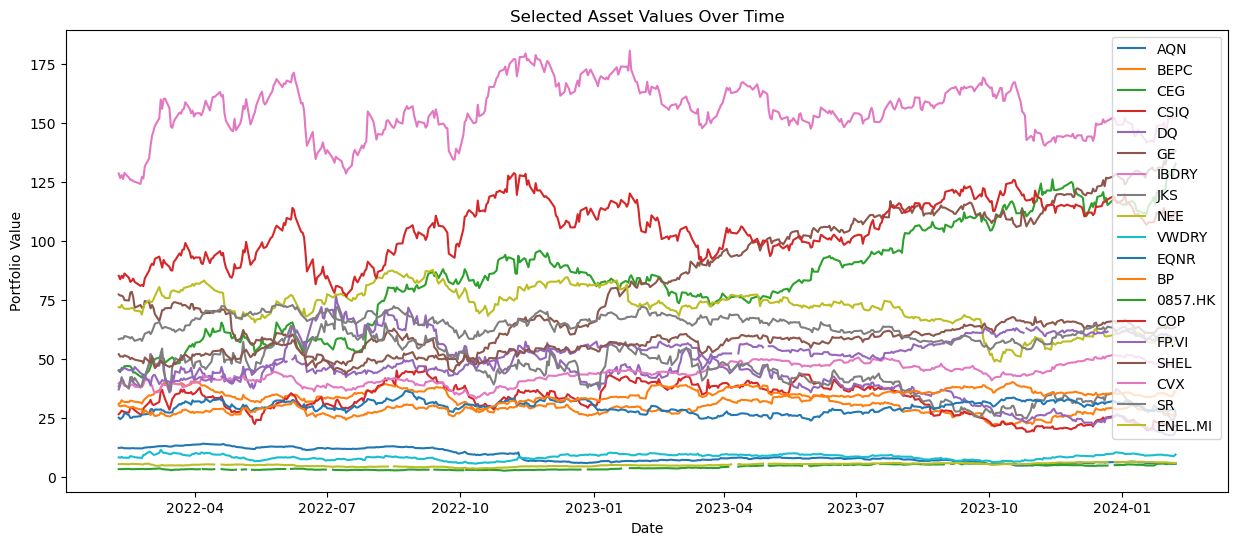

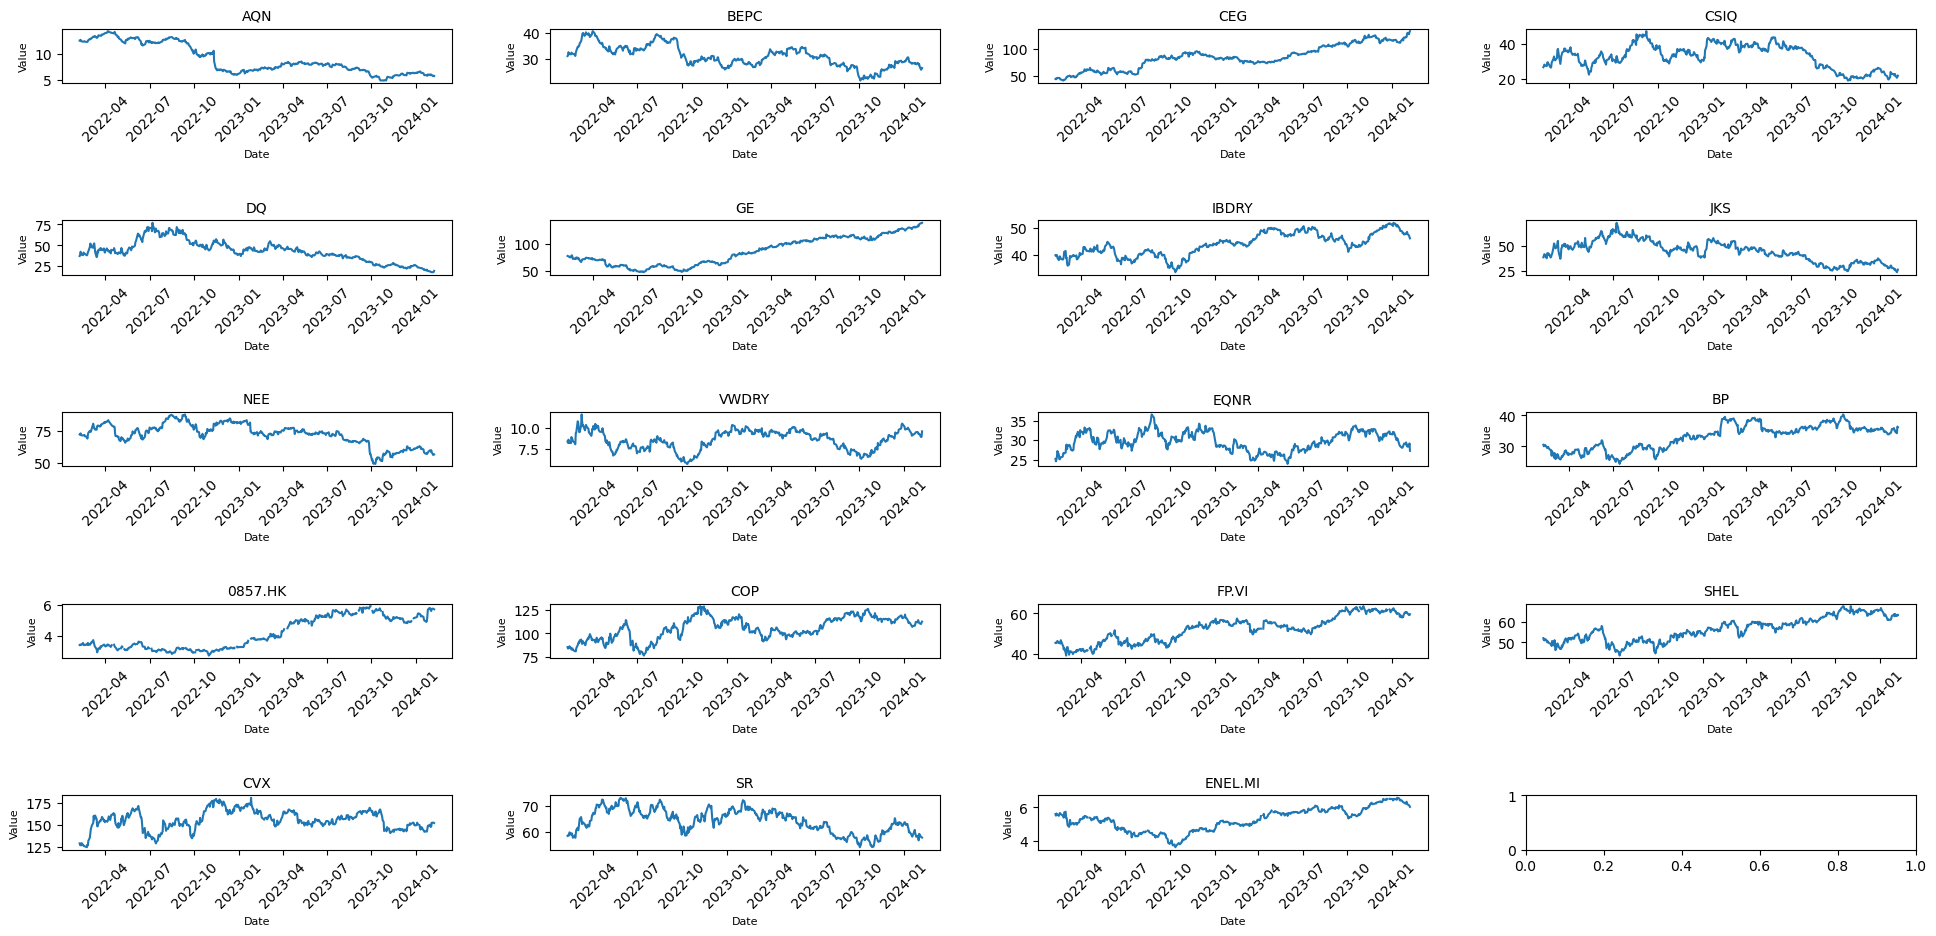

Box plot for distribution analysis


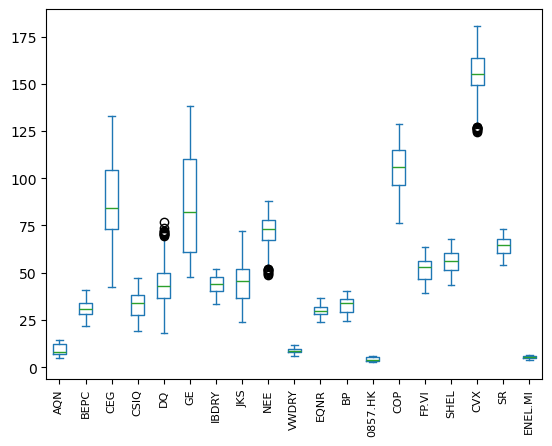

Heatmap for Correlation Between Assets


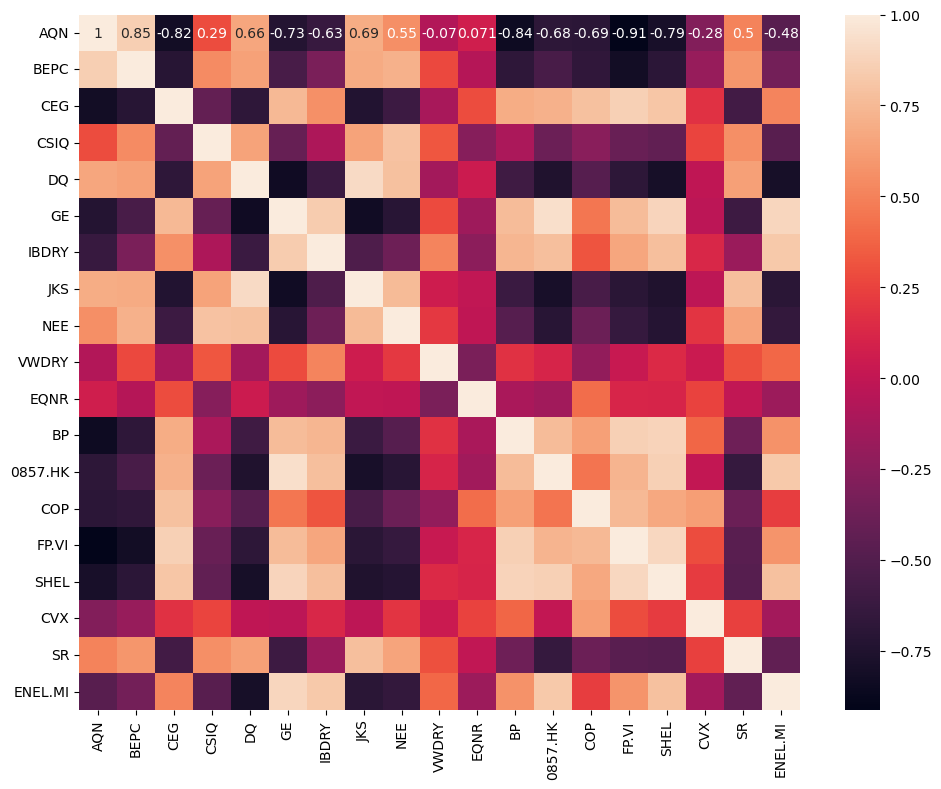

In [14]:
# Primary analysis
analyze_dataset(adj_close_df, summary_stat= True, data_quality = True, exploratory_analysis= True)

## Portfolio analysis

In [7]:
invested_amount = float(input("Enter amount to invest: "))

Enter amount to invest:  364864888


Enter the amount of dollars you would like to invest, this amount will be spent on different stocks, press enter to submit!:)

#### Optimal weights of assets

Maxmimum Expected Return Method:
Expected Annual Return: 0.3005
Expected Volatility: 0.2052
Sharpe Ratio: 1.5617
Minimum Variance Method:
Expected Annual Return: 0.1072
Expected Volatility: 0.1439
Sharpe Ratio: 0.8838
Maximum Sharpe Ratio Method:
Expected Annual Return: 0.2708
Expected Volatility: 0.1718
Sharpe Ratio: 1.6932


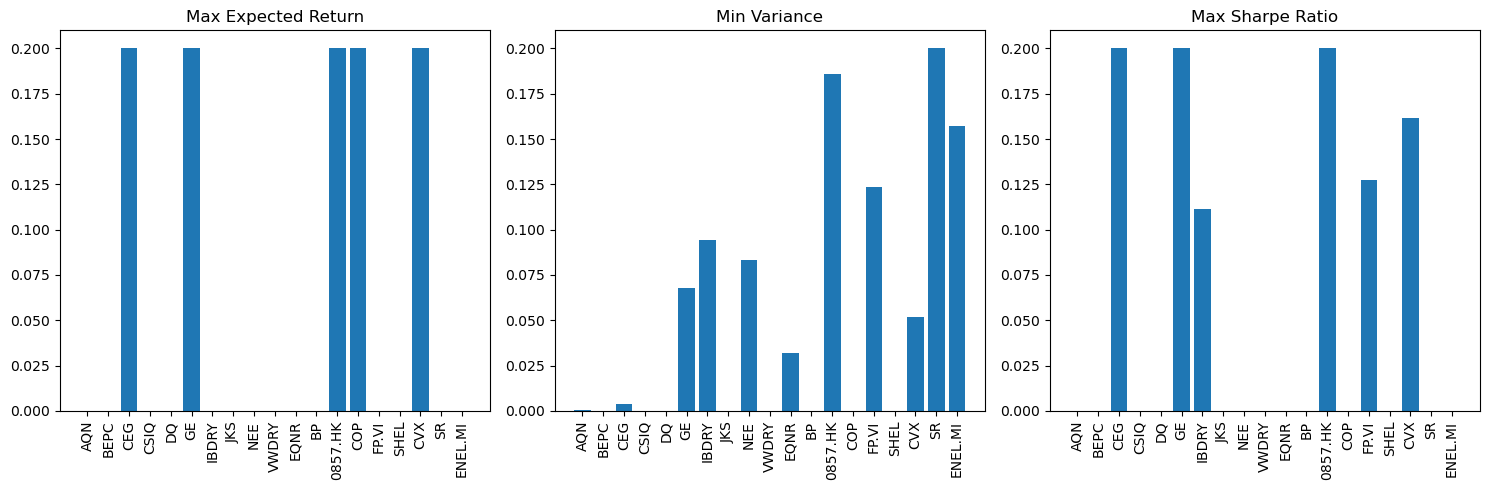

In [8]:
# Auxiliary variables for analysis
log_returns = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
cov_matrix = log_returns.cov() * 252

# Optimal portfolio information for max_exp_return
optimal_result_max_exp_return = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_exp_return")
optimal_weights_max_exp_return = optimal_result_max_exp_return.x

# Optimal portfolio information for min_variance
optimal_result_min_variance = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="min_variance")
optimal_weights_min_variance = optimal_result_min_variance.x

# Optimal portfolio information for max_sharpe
optimal_result_max_sharpe = optimize_portfolio(adj_close_df, min_weight=0.0, max_weight=0.2, method="max_sharpe")
optimal_weights_max_sharpe = optimal_result_max_sharpe.x

# variance, expected return and Sharpe Ratio for each method

# Max. Expected return
max_exp_return = -neg_expected_return(optimal_weights_max_exp_return, log_returns = log_returns)
max_exp_volatility = standard_deviation(optimal_weights_max_exp_return, cov_matrix)
max_exp_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_exp_return, log_returns, cov_matrix, 0.02)

# Min. Variance
min_vol_return = -neg_expected_return(optimal_weights_min_variance, log_returns = log_returns)
min_vol_volatility = standard_deviation(optimal_weights_min_variance, cov_matrix)
min_vol_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_min_variance, log_returns, cov_matrix, 0.02)

# Max. Sharpe Ratio
max_sharpe_return = -neg_expected_return(optimal_weights_max_sharpe, log_returns = log_returns)
max_sharpe_vol = standard_deviation(optimal_weights_max_sharpe, cov_matrix)
max_sharpe_sharpe = (-1)*neg_sharpe_ratio(optimal_weights_max_sharpe, log_returns, cov_matrix, 0.02)

# show the portfolio information for each:
print("Maxmimum Expected Return Method:")
print(f"Expected Annual Return: {max_exp_return:.4f}")
print(f"Expected Volatility: {max_exp_volatility:.4f}")
print(f"Sharpe Ratio: {max_exp_sharpe:.4f}")

print("Minimum Variance Method:")
print(f"Expected Annual Return: {min_vol_return:.4f}")
print(f"Expected Volatility: {min_vol_volatility:.4f}")
print(f"Sharpe Ratio: {min_vol_sharpe:.4f}")

print("Maximum Sharpe Ratio Method:")
print(f"Expected Annual Return: {max_sharpe_return:.4f}")
print(f"Expected Volatility: {max_sharpe_vol:.4f}")
print(f"Sharpe Ratio: {max_sharpe_sharpe:.4f}")

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

# Plot for max_exp_return
axs[0].bar(tickers, optimal_weights_max_exp_return)
axs[0].set_title('Max Expected Return')
axs[0].tick_params(axis='x', rotation=90)

# Plot for min_variance
axs[1].bar(tickers, optimal_weights_min_variance)
axs[1].set_title('Min Variance')
axs[1].tick_params(axis='x', rotation=90)

# Plot for max_sharpe
axs[2].bar(tickers, optimal_weights_max_sharpe)
axs[2].set_title('Max Sharpe Ratio')
axs[2].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

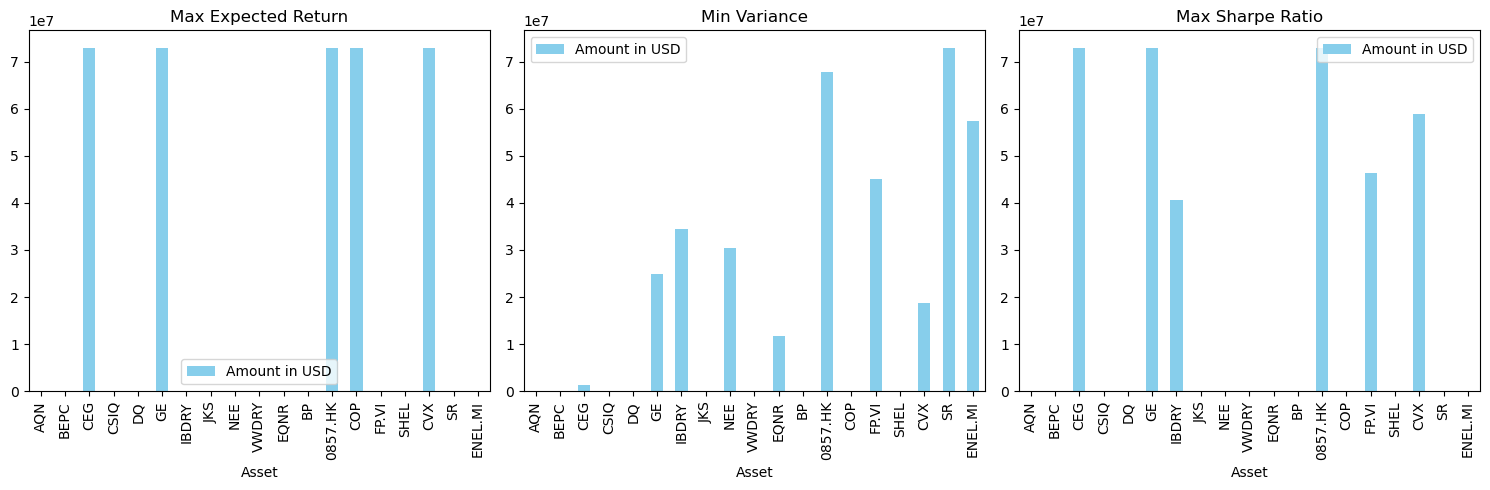

In [9]:
# Portfolio dataframe for max_exp
positions_max_exp = np.round(optimal_result_max_exp_return.x*float(invested_amount))
portfolio_max_exp = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_exp})

# Portfolio dataframe for min_variance
positions_min_variance = np.round(optimal_result_min_variance.x * float(invested_amount))
portfolio_min_variance = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_min_variance})

# Portfolio dataframe for max_sharpe
positions_max_sharpe = np.round(optimal_result_max_sharpe.x * float(invested_amount))
portfolio_max_sharpe = pd.DataFrame({'Asset': tickers, 'Amount in USD': positions_max_sharpe})

# Displaying portfolio breakdowns side by side
fig, axs = plt.subplots(1, 3, figsize=(15, 5))  # 1 row, 3 columns

# Plot for max_exp_return
portfolio_max_exp.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[0])
axs[0].set_title('Max Expected Return')

# Plot for min_variance
portfolio_min_variance.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[1])
axs[1].set_title('Min Variance')

# Plot for max_sharpe
portfolio_max_sharpe.plot(x='Asset', y='Amount in USD', kind='bar', color='skyblue', ax=axs[2])
axs[2].set_title('Max Sharpe Ratio')

# Adjust layout
plt.tight_layout()

plt.show()

Maximum Expected Return Method Sustainability Weights:
Sustainable Weight: 0.4000
Unsustainable Weight: 0.6000
According to the optimizing strategy 'Maximum Expected Return', the situation and market prefers unsustainable companies.
---

Minimum Variance Method Sustainability Weights:
Sustainable Weight: 0.2497
Unsustainable Weight: 0.7503
According to the optimizing strategy 'Minimum Variance', the situation and market prefers unsustainable companies.
---

Maximum Sharpe Ratio Method Sustainability Weights:
Sustainable Weight: 0.5114
Unsustainable Weight: 0.4886
According to the optimizing strategy 'Maximum Sharpe Ratio', the situation and market is even between sustainable and unsustainable companies.
---



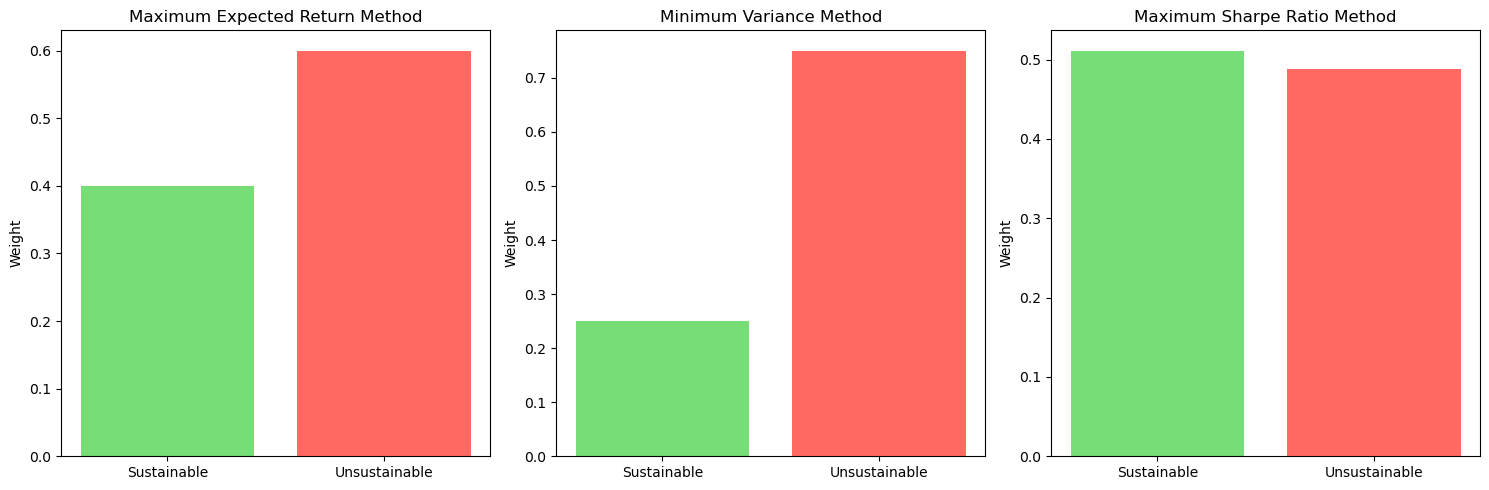

In [12]:
optimal_weights = [optimal_weights_max_exp_return, optimal_weights_min_variance, optimal_weights_max_sharpe]
method_names = ['Maximum Expected Return', 'Minimum Variance', 'Maximum Sharpe Ratio']

summaries = process_results_and_generate_summaries(optimal_weights, tickers, sustainable_stocks, unsustainable_stocks, method_names)


end of code